In [1]:
import sys
sys.path.append("..")

In [119]:
import os
import h5py
from random import sample

from rdkit.Chem import MolFromSmiles
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

from src.data_preprocessing.cyp450_scaffold_splitting import ScaffoldSplitter

In [47]:
class MySplitter(ScaffoldSplitter):
    
    def get_clusters(self, fp_field, smiles_field):
        # create dict of the form {scaffold_i: [idx1, idx....]}
        all_scaffolds = {}
        it = tqdm(
            zip(self.dataset[fp_field], self.dataset[smiles_field]),
            total=self.dataset[smiles_field].len(),
            desc="Clustering"
        )
        for fp, smiles in it:
            if MolFromSmiles(smiles) is None:
                continue
            scaffold = self._generate_scaffold(smiles, include_chirality=True)
            if scaffold not in all_scaffolds:
                all_scaffolds[scaffold] = [[smiles, fp]]
            else:
                all_scaffolds[scaffold].append([smiles, fp])

        return all_scaffolds

In [45]:
chembl_h5f = h5py.File(os.path.join("..", "data", "ChEMBL24.hdf5"), "r")

In [48]:
splitter = MySplitter(chembl_h5f)

all_scaffolds = splitter.get_clusters("ChEMBL/ECFP", "ChEMBL/SMILES")

In [58]:
chembl_h5f.close()

In [72]:
clusters_h5f = h5py.File(os.path.join("..", "data", "ChEMBL24_scaffold_clusters.hdf5"), "w")
dt = h5py.string_dtype(encoding="utf-8")
it = tqdm(
    enumerate(all_scaffolds.items()),
    desc="Write clusters",
    total=len(all_scaffolds)
)
for i, [scaffold, data] in it:
    grp = clusters_h5f.create_group(f"cluster_{i}")
    grp.attrs.create("scaffold", str(scaffold), dtype=dt)
    grp.create_dataset("SMILES", data=np.array([d[0] for d in data]).astype(bytes), dtype=dt)
    grp.create_dataset("ECFP", data=np.array([d[1] for d in data]), dtype="int8")

In [74]:
clusters_h5f.close()

In [75]:
clusters_h5f = h5py.File(os.path.join("..", "data", "ChEMBL24_scaffold_clusters.hdf5"), "r")

In [107]:
counter = [0] * 5
for data in tqdm(clusters_h5f.values()):
    l = data["SMILES"].len()
    if l == 1:
        counter[0] += 1
    elif 1 < l <= 5:
        counter[1] += 1
    elif 5 < l <= 10:
        counter[2] += 1
    elif 10 < l < 50:
        counter[3] += 1
    elif l >= 50:
        counter[4] += 1
    else:
        print(data, "have wrong length.")

In [108]:
print(counter)

[340390, 133853, 26230, 22189, 2431]


<BarContainer object of 5 artists>

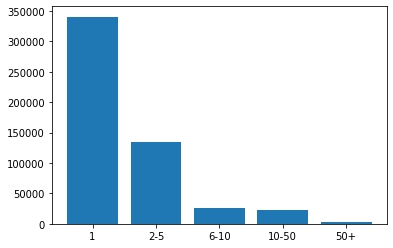

In [109]:
plt.bar(["1", "2-5", "6-10", "10-50", "50+"], counter)


[340390, 133853, 26230, 17146, 7474]


<BarContainer object of 5 artists>

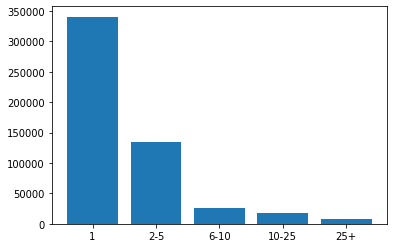

In [111]:
counter = [0] * 5
for data in tqdm(clusters_h5f.values()):
    l = data["SMILES"].len()
    if l == 1:
        counter[0] += 1
    elif 1 < l <= 5:
        counter[1] += 1
    elif 5 < l <= 10:
        counter[2] += 1
    elif 10 < l < 25:
        counter[3] += 1
    elif l >= 25:
        counter[4] += 1
    else:
        print(data, "have wrong length.")
print(counter)

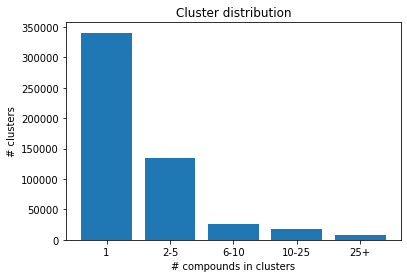

In [118]:
plt.bar(["1", "2-5", "6-10", "10-25", "25+"], counter)
plt.xlabel("# compounds in clusters")
plt.ylabel("# clusters")
_ = plt.title("Cluster distribution")
plt.savefig(os.path.join("..", "data", "chembl24_scaffold_cluster_distribution.png"))

In [152]:
with h5py.File(os.path.join("..", "data", "ChEMBL24_scaffold_clusters_sampled.hdf5"), "w") as f:
    for key, data in tqdm(clusters_h5f.items(), total=525093, desc="Sampling from clusters"):
        grp = f.create_group(key)
        if data["SMILES"].len() <= 2:
            grp.create_dataset("SMILES", data=data["SMILES"])
            grp.create_dataset("ECFP", data=data["ECFP"])
        else:
            indices = sorted(sample(list(range(data["SMILES"].len())), 2))
            smiles = data["SMILES"][indices]
            ecfp = data["ECFP"][indices]
#             grp.create_dataset("SMILES", data=smiles.astype(bytes), dtype=dt)
            grp.create_dataset("SMILES", data=smiles)
            grp.create_dataset("ECFP", data=ecfp, dtype="int8")

In [154]:
with h5py.File(os.path.join("..", "data", "ChEMBL24_scaffold_clusters_sampled.hdf5"), "r") as f:
    for data in tqdm(f.values(), total=525093, desc="Assert groups"):
        assert data["SMILES"].len() == data["ECFP"].len()
        assert data["SMILES"].len() <= 2, data["SMILES"].len()